# Predicting HDB Resale Prices in Singapore III

## Model Building
In this part, we will use our final dataset to build models to predict existing resale prices.

---

### Importing Necessary Packages

In this part, we will be using standardisation and feature encoding to prepare our features for model building. We will also be building pipelines using the scikit-learn library and using various supervised learning techniques to build models.

In [30]:
# Importing necessary packages

import pandas as pd
import numpy as np
import scipy.stats as stat
import pylab
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn_pandas import DataFrameMapper
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import pickle


from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

pd.set_option("display.max_columns", None)

In [2]:
# Importing dataset

resale_df = pd.read_csv('data/resale_prices_final.csv')

In [3]:
# Examining dataset

resale_df.head()

,town,flat_type,flat_model,floor_area_sqm,street_name,resale_price,month,remaining_lease,lease_commence_date,storey_range,_id,block,address,r_address,latitude,longitude,nearest_mrt,nearest_mrt_dist,nearest_pri_sch,nearest_pri_sch_dist,nearest_sec_sch,nearest_sec_sch_dist,nearest_mall,nearest_mall_dist,quarter,inflation_price,lease_deci,mid_storey
0,ANG MO KIO,2 ROOM,Improved,44.0,ANG MO KIO AVE 10,232000.0,2017-01,61 years 04 months,1979,10 TO 12,1,406,406 ANG MO KIO AVENUE 10,406 ANG MO KIO AVENUE 10,1.362005,103.853880,ANG MO KIO MRT STATION,1.000002,TOWNSVILLE PRIMARY SCHOOL,0.218124,DEYI SECONDARY SCHOOL,0.465777,AMK Hub,1.014089,2017Q1,253657.953698,61.333333,11
1,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 4,250000.0,2017-01,60 years 07 months,1978,01 TO 03,2,108,108 ANG MO KIO AVENUE 4,108 ANG MO KIO AVENUE 4,1.370966,103.838202,MAYFLOWER MRT STATION,0.190030,ANG MO KIO PRIMARY SCHOOL,0.241601,MAYFLOWER SECONDARY SCHOOL,0.434455,Broadway Plaza,0.869109,2017Q1,273338.312175,60.583333,2
2,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 5,262000.0,2017-01,62 years 05 months,1980,01 TO 03,3,602,602 ANG MO KIO AVENUE 5,602 ANG MO KIO AVENUE 5,1.380709,103.835368,LENTOR MRT STATION,0.532151,MAYFLOWER PRIMARY SCHOOL,0.506847,PRESBYTERIAN HIGH SCHOOL,0.789393,Broadway Plaza,1.525833,2017Q1,286458.551159,62.416667,2
3,ANG MO KIO,3 ROOM,New Generation,68.0,ANG MO KIO AVE 10,265000.0,2017-01,62 years 01 month,1980,04 TO 06,4,465,465 ANG MO KIO AVENUE 10,465 ANG MO KIO AVENUE 10,1.366201,103.857201,ANG MO KIO MRT STATION,0.945591,TECK GHEE PRIMARY SCHOOL,0.691887,DEYI SECONDARY SCHOOL,0.518707,myVillage At Serangoon Garden,0.894047,2017Q1,289738.610906,62.083333,5
4,ANG MO KIO,3 ROOM,New Generation,67.0,ANG MO KIO AVE 5,265000.0,2017-01,62 years 05 months,1980,01 TO 03,5,601,601 ANG MO KIO AVENUE 5,601 ANG MO KIO AVENUE 5,1.381041,103.835132,LENTOR MRT STATION,0.498418,MAYFLOWER PRIMARY SCHOOL,0.546442,PRESBYTERIAN HIGH SCHOOL,0.811047,Broadway Plaza,1.569570,2017Q1,289738.610906,62.416667,2


---

### Examining Distribution of Features

Before we begin model building, it is important to examine the distribution of our data. Data that is skewed can have negative effects on the accuracy of models, and should be addressed before models trained with the data. One way we could examine whether data is skewed is using a quantile-quantile (QQ) plot.

For the resale price, we can see that the data is skewed towards the right. We can confirm this by calculating the median and mean values, and confirming that the median is smaller than the mean. This would indicate that some Gaussian transformation needs to be applied to the data. Here, we choose to apply the Log Transformation on our resale price data. After the transformation, we can see from the QQ plot that the data is more normally distributed.

In [4]:
# Separating features used for model building

continuous_features = ['floor_area_sqm', 'nearest_mrt_dist', 'nearest_pri_sch_dist', 'nearest_sec_sch_dist', 'nearest_mall_dist', 'lease_deci']
categorical_features = ['town', 'flat_type', 'flat_model', 'mid_storey']

In [5]:
# Function to plot histogram and QQ plot of feature

def plot_data(df, feature, method):
    plt.subplot(1,2,1)
    df[feature].hist()
    plt.subplot(1,2,2)
    stat.probplot(df[feature], dist='norm', plot=pylab)
    plt.title(method)
    plt.tight_layout()
    plt.show()

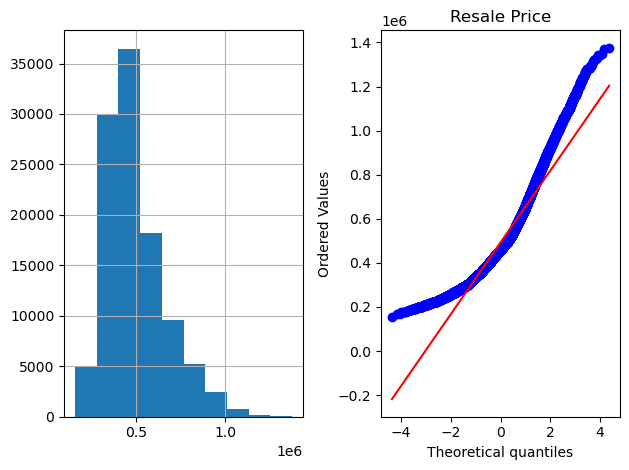

Median Resale Price: 459895.287978
Mean Resale Price: 492537.5479026215


In [13]:
# Examining distribution of inflation price (dependent variable)

plot_data(resale_df, 'inflation_price', 'Resale Price')
print('Median Resale Price: {}'.format(resale_df.inflation_price.median()))
print('Mean Resale Price: {}'.format(resale_df.inflation_price.mean()))

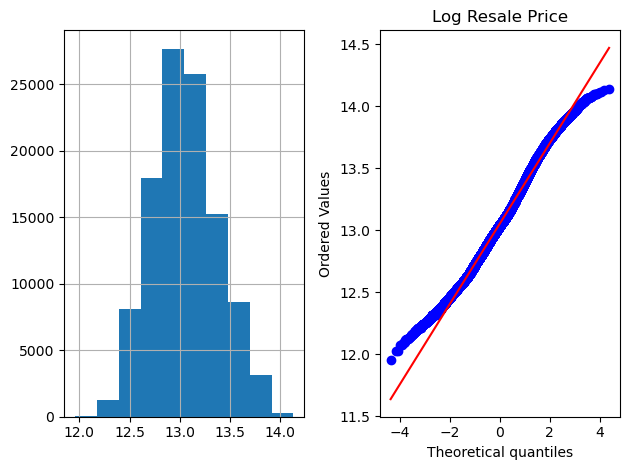

Median Resale Price: 13.038754107722102
Mean Resale Price: 13.053236607105923


In [14]:
# Examining distribution of inflation price (dependent variable) after Log Transformation

temp_df = resale_df.copy()
temp_df['inflation_price'] = np.log1p(temp_df['inflation_price'])
plot_data(temp_df, 'inflation_price', 'Log Resale Price')
print('Median Resale Price: {}'.format(temp_df.inflation_price.median()))
print('Mean Resale Price: {}'.format(temp_df.inflation_price.mean()))

---

### Obtaining Training and Testing Data

We use the train_test_split function to split our dataset into a training set to train the model and a testing set to validate the accuracy of the model. 

In [5]:
# Train Test Split to obtain training and testing data. We set testing data to be 20% of total dataset.

X = resale_df[continuous_features+categorical_features]
y = np.log1p(resale_df['inflation_price'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

---

### Linear Regression

The first model we use to model resale prices is Linear Regression. For linear regression, we have to do some pre-processing to our features before we can apply the model. As with the other models later, we will use Scikit-learn's Pipeline to perform pre-processing and model fitting together. While not necessary, this makes our code for pre-processing and model fitting cleaner.

For continuous features, we apply Log Transformation to normalise the feature, similar to what was done for resale price. We then scale the continuous variables using the StandardScaler. For the categorical variables, we apply OneHotEncoder to encode the categories into separate columns.

We see that the model has a high R^2 of 0.91, meaning that around 91% of the variability in resale price can be explained by the features. It also has a low mean absolute error of 0.0773 and root mean squared error of 0.0096. That being said, without any other models for comparison for now, we cannot explicitly say that the linear regression is a good model to predict resale price.

In [5]:
# Initialising preprocessing steps for features

transformer = FunctionTransformer(np.log1p, validate=False)

mapper = DataFrameMapper([
    (continuous_features, [transformer, StandardScaler()]),
    (categorical_features, OneHotEncoder())], df_out=True)

In [12]:
# Building pipeline and training Linear Regression Model

lr_pipeline = Pipeline(steps=[
    ('preprocessing', mapper),
    ('regressor', LinearRegression())])

lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 DataFrameMapper(df_out=True, drop_cols=[],
                                 features=[(['floor_area_sqm',
                                             'nearest_mrt_dist',
                                             'nearest_pri_sch_dist',
                                             'nearest_sec_sch_dist',
                                             'nearest_mall_dist',
                                             'lease_deci'],
                                            [FunctionTransformer(func=<ufunc 'log1p'>),
                                             StandardScaler()]),
                                           (['town', 'flat_type', 'flat_model',
                                             'mid_storey'],
                                            OneHotEncoder())])),
                ('regressor', LinearRegression())])

In [13]:
# Examining model accuracy metrics

print('Linear Regression R^2: {}'.format(lr_pipeline.score(X_test, y_test)))
print('Linear Regression MAE: {}'.format(mean_absolute_error(y_test, lr_pipeline.predict(X_test))))
print('Linear Regression RMSE: {}'.format(mean_squared_error(y_test, lr_pipeline.predict(X_test)), squared=False))

Linear Regression R^2: 0.9100122637032904
Linear Regression MAE: 0.07731502570316141
Linear Regression RMSE: 0.009617181842247916


### Ridge Regression

An alternative linear model to consider would be Ridge Regression. Ridge Regression works in a similar way to Linear Regression; the difference being that higher slope values are penalised. This reduces overfitting as compared to the Linear Regression model. For the regressor, we use RidgeCV, which performs the cross validation in the regressor itself. For the pipeline, we do a similar treatment to the continuous and categorical variables as we did for Linear Regression.

For Ridge Regression, we get an R^2 value of 0.91, with a mean absolute error of 0.077 and a root mean squared error of 0.0096. We notice that the results for the Ridge Regression are very similar to the Linear Regression model. This could be an indicator that our original Linear Regression model likely did not overfit the training data.

In [18]:
# Building pipeline for Ridge Regression model

r_pipeline = Pipeline(steps=[
    ('preprocessing', mapper),
    ('regressor', RidgeCV())])

r_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 DataFrameMapper(df_out=True, drop_cols=[],
                                 features=[(['floor_area_sqm',
                                             'nearest_mrt_dist',
                                             'nearest_pri_sch_dist',
                                             'nearest_sec_sch_dist',
                                             'nearest_mall_dist',
                                             'lease_deci'],
                                            [FunctionTransformer(func=<ufunc 'log1p'>),
                                             StandardScaler()]),
                                           (['town', 'flat_type', 'flat_model',
                                             'mid_storey'],
                                            OneHotEncoder())])),
                ('regressor', RidgeCV(alphas=array([ 0.1,  1. , 10. ])))])

In [19]:
# Examining model accuracy metrics

print('Ridge Regression R^2: {}'.format(r_pipeline.score(X_test, y_test)))
print('Ridge Regression MAE: {}'.format(mean_absolute_error(y_test, r_pipeline.predict(X_test))))
print('Ridge Regression RMSE: {}'.format(mean_squared_error(y_test, r_pipeline.predict(X_test)), squared=False))

Ridge Regression R^2: 0.9100113301570217
Ridge Regression MAE: 0.07731725659884622
Ridge Regression RMSE: 0.009617281612334293


### Random Forest Regressor

Instead of linear models, we could also consider using tree-based models. The difference here is that we would not be required to perform standardisation for the continuous features, since this does not affect tree-based models. The first model we try is a Random Forest regressor.

The Random Forest model returned an R^2 value of 0.97, with a mean squared error of 0.043 and a root mean squared error of 0.0033. We see that in all three metrics, the Random Forest model performed better than the linear models. One reason for the better performance is that tree-based models discared the biggest assumption of linear models: that the features affect the resale price in a linear manner. As a result, tree-based models are able to discover more intricate relations to the features, and would have better performance.

In [6]:
# Initiating preprocessing steps for features

rf_mapper = DataFrameMapper([
    (continuous_features, None),
    (categorical_features, OneHotEncoder())], df_out=True)

In [7]:
# Building pipeline and training Random Forest Regressor

rf_pipeline = Pipeline(steps=[
    ('preprocessing', rf_mapper),
    ('regressor', RandomForestRegressor())])

rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 DataFrameMapper(df_out=True, drop_cols=[],
                                 features=[(['floor_area_sqm',
                                             'nearest_mrt_dist',
                                             'nearest_pri_sch_dist',
                                             'nearest_sec_sch_dist',
                                             'nearest_mall_dist',
                                             'lease_deci'],
                                            None),
                                           (['town', 'flat_type', 'flat_model',
                                             'mid_storey'],
                                            OneHotEncoder())])),
                ('regressor', RandomForestRegressor())])

In [10]:
# Examining model accuracy metrics

print('Random Forest R^2: {}'.format(rf_pipeline.score(X_test, y_test)))
print('Random Forest MAE: {}'.format(mean_absolute_error(y_test, rf_pipeline.predict(X_test))))
print('Random Forest RMSE: {}'.format(mean_squared_error(y_test, rf_pipeline.predict(X_test)), squared=False))

Random Forest R^2: 0.9688789318911311
Random Forest MAE: 0.04286669915249112
Random Forest RMSE: 0.0033259751099986093


For the Random Forest model, there is a set of hyperparameters that can be modifed for the model, including max tree depth, number of samples for each leaf, etc. These hyperparameters can be tuned to achieve better model accuracy. In our case, we use RandomisedSearchCV to try random combinations of hyperparameter values to find the best set for our model. An alternative and more comprehensive way would be to use GridSearchCV to run through every combination. However, as the training time for the Random Forest model is much longer than linear models, we chose to use Randomised Search to cut down on the runtime.

In [18]:
# Hyperparamerter Optimisation

param_grid = {
    'regressor__max_depth': [30, 40, 50, 60, 70],
    'regressor__min_samples_leaf': [1, 3, 5],
    'regressor__min_samples_split': [2, 4, 8, 16],
    'regressor__n_estimators': [100, 200, 300, 1000]}

search = RandomizedSearchCV(rf_pipeline, param_grid, verbose=1, n_jobs=1, random_state=42)
search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                              DataFrameMapper(df_out=True,
                                                              drop_cols=[],
                                                              features=[(['floor_area_sqm',
                                                                          'nearest_mrt_dist',
                                                                          'nearest_pri_sch_dist',
                                                                          'nearest_sec_sch_dist',
                                                                          'nearest_mall_dist',
                                                                          'lease_deci'],
                                                                         None),
                                                                        (['town',
                                                          

In [25]:
# Obtaining the best hyperparameter values from the randomised search

search.best_params_

{'regressor__n_estimators': 100,
 'regressor__min_samples_split': 8,
 'regressor__min_samples_leaf': 1,
 'regressor__max_depth': 50}

In [26]:
# Constructing a Random Forest pipeline with the optimal hyperparameters

rf_best_params = {'n_estimators': 100,
 'min_samples_split': 8,
 'min_samples_leaf': 1,
 'max_depth': 50}


rf_best = Pipeline(steps=[
    ('preprocessing', rf_mapper),
    ('regressor', RandomForestRegressor(**rf_best_params))])

rf_best.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 DataFrameMapper(df_out=True, drop_cols=[],
                                 features=[(['floor_area_sqm',
                                             'nearest_mrt_dist',
                                             'nearest_pri_sch_dist',
                                             'nearest_sec_sch_dist',
                                             'nearest_mall_dist',
                                             'lease_deci'],
                                            None),
                                           (['town', 'flat_type', 'flat_model',
                                             'mid_storey'],
                                            OneHotEncoder())])),
                ('regressor',
                 RandomForestRegressor(max_depth=50, min_samples_split=8))])

In [27]:
# Examining model accuracy metrics

print('Best Random Forest R^2: {}'.format(rf_best.score(X_test, y_test)))
print('Best Random Forest MAE: {}'.format(mean_absolute_error(y_test, rf_best.predict(X_test))))
print('Best Random Forest RMSE: {}'.format(mean_squared_error(y_test, rf_best.predict(X_test)), squared=False))

Best Random Forest R^2: 0.9690918901533787
Best Random Forest MAE: 0.04284201621748797
Best Random Forest RMSE: 0.0033032158050407445


### XGBoost Regressor

For the final type of model, we will be using boosted trees from XGBoost Regressor. Similar to the Random Forest implementation, we will be encoding the categorical variables and using hyperparameter tuning to find the optimal hyperparameters. In this case, since XGBoost models train faster than Random Forest Models, we will be carrying out Grid Search instead of Randomised Search to obtain the best hyperparameters.

For this XGBoost model, we obtain an R^2 value of 0.97, with a mean absolute error of 0.044 and a root mean squared error of 0.0033. In comparison to our Random Forest model, our XGBoost model has a higher R^2 value and a lower RMSE value. As such, we would be using this model as the final model for implementation into our API.

In [ ]:
# Building pipeline and performing Grid Search

xgb_pipeline = Pipeline(steps=[
    ('preprocessing', rf_mapper),
    ('regressor', XGBRegressor())])

param_grid = {
    'regressor__learning_rate': [0.05, 0.10, 0.20, 0.30],
    'regressor__max_depth': [4, 6, 8, 10],
    'regressor__min_child_weight': [1, 3, 5],
    'regressor__gamma': [0.0, 0.1, 0.2, 0.3],
    'regressor__colsample_bytree': [0.3, 0.5, 0.7, 1]}

search = GridSearchCV(xgb_pipeline, param_grid, verbose=1, n_jobs=1, cv=3)
search.fit(X_train, y_train)

In [31]:
# Constructing an XGBoost pipeline with the optimal hyperparameters# 

xgb_best_params = {'colsample_bytree': 0.7,
 'gamma': 0.0,
 'learning_rate': 0.2,
 'max_depth': 10,
 'min_child_weight': 5}

xgb_best = Pipeline(steps=[
    ('preprocessing', rf_mapper),
    ('regressor', XGBRegressor(**xgb_best_params))])

xgb_best.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 DataFrameMapper(df_out=True, drop_cols=[],
                                 features=[(['floor_area_sqm',
                                             'nearest_mrt_dist',
                                             'nearest_pri_sch_dist',
                                             'nearest_sec_sch_dist',
                                             'nearest_mall_dist',
                                             'lease_deci'],
                                            None),
                                           (['town', 'flat_type', 'flat_model',
                                             'mid_storey'],
                                            OneHotEncoder())])),
                ('regressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_byleve...
                              colsample_bytree=0.7, gamma=0.0, gpu_id=-1,
                              importance

In [33]:
# Examining model accuracy metrics

print('Best XGBoost R^2: {}'.format(xgb_best.score(X_test, y_test)))
print('Best XGBoost MAE: {}'.format(mean_absolute_error(y_test, xgb_best.predict(X_test))))
print('Best XGBoost RMSE: {}'.format(mean_squared_error(y_test, xgb_best.predict(X_test)), squared=False))

Best XGBoost R^2: 0.9692660355426184
Best XGBoost MAE: 0.04362216956090591
Best XGBoost RMSE: 0.003284604514833555


### Making Predictions

Now that we have our trained model, we can use it to make predictions about resale prices. We will be using the second entry in our test dataset as an example. We can see below the features of this resale flat in Hougang. In order to make predictions, we run this entry through the XGBoost pipeline, and obtain a predicted value.

The output value of 12.55 doesnt seem quite right. Since we previously did an log-transformation to the resale prices when training our model, the output prediction is in the log scale. To convert it back, we will be doing the reverse of what we did to the original resale prices (i.e. subtracting 1 and taking the exponent of this value). We end up with a final price of \\$282,337. We see that for this particular entry, the predicted price is quite close to the actual resale price of \\$280,000.

In [70]:
# Examining the first sample of the test data

sample = pd.DataFrame(X_test.iloc[1]).transpose()
sample[continuous_features] = sample[continuous_features].astype(float)
sample

,floor_area_sqm,nearest_mrt_dist,nearest_pri_sch_dist,nearest_sec_sch_dist,nearest_mall_dist,lease_deci,town,flat_type,flat_model,mid_storey
102198,60.0,1.217217,0.185306,0.198379,0.489944,64.666667,HOUGANG,3 ROOM,Improved,5


In [71]:
# Obtaining predicted value for first sample

predicted = xgb_best.predict(sample)
predicted

array([12.55086], dtype=float32)

In [72]:
# Converting resale price in log scale back into dollars, and comparing it to the actual resale price

price = np.expm1(predicted)
actual = np.expm1(y_test.iloc[1])

print("Predicted Resale Price: ${}".format(round(price[0],0)))
print("Actual Resale Price: ${}".format(round(actual,0)))

Predicted Resale Price: $282337.0
Actual Resale Price: $280000.0


### Saving Model

Finally, to avoid re-training our model every time, we will be saving the trained model to a Pickle file.

In [ ]:
pickle.dump(xgb_best, open('resale_prices_deployment/xgb_best.sav', 'wb'))